In [2]:
from dottamine import dotim
import numpy as np
import skimage as sk
# import napari
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import center_of_mass, rotate, gaussian_filter, zoom
import matplotlib.pyplot as plt
import copy

In [3]:
mask = sk.io.imread('domes/70_denoised_mask.tif').astype(np.uint8)
image = sk.io.imread('domes/70_denoised.tif')
original_image = copy.copy(image[3])
image = np.transpose(image[3], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

In [4]:
## Close the mask
closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

## Find the top line of the mask
closed_mask = np.array(closed_mask)
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
first_nonzero_indices = first_nonzero_indices

## Move up or down the line
first_nonzero_indices = first_nonzero_indices + 0 # Units to move the line. If > 0  the line will be lower, useful to get the basal? If < 0 the line will be higher.
first_nonzero_indices[first_nonzero_indices < 0] = 0
first_nonzero_indices[first_nonzero_indices >= closed_mask.shape[1]] = closed_mask.shape[1]-1
## Fi move up or down the line

top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask

top_mask[:,0,:] = 0

top_mask = top_mask.astype(np.float64)

filtered = gaussian_filter(top_mask, 60) ## Original gaussian -> 30
epithelial = filtered*image


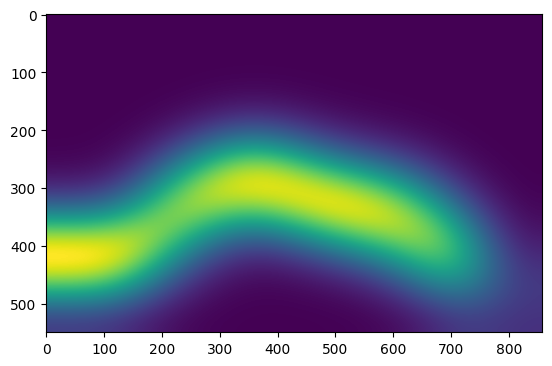

In [5]:
plt.imshow(filtered[300])

In [6]:
epith_dot = dotim(epithelial, is2D=False, treat_3D_as_2D=False)
mask_epith = epith_dot.get_mask(times=3, binshape=(2,2,2), v='+')

Convolving: 1/3
Convolving: 2/3
Convolving: 3/3
Deconvolving: 3/3
Deconvolving: 2/3
Deconvolving: 1/3


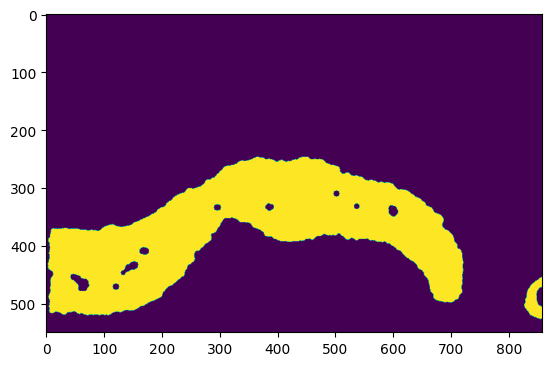

In [8]:
plt.imshow(mask_epith[400])
# plt.imshow(epithelial[400])

In [10]:
mask_epith = mask_epith.astype(np.uint8)

In [11]:
## Close the mask
closed_mask = []
for i in mask_epith:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

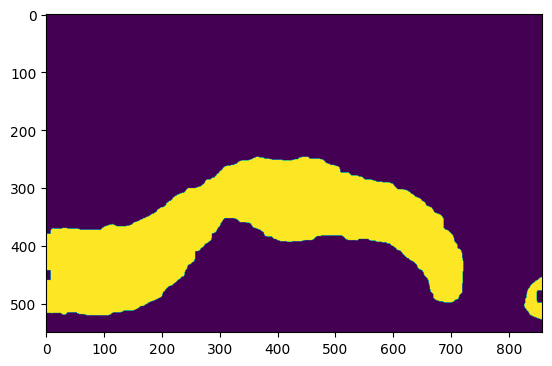

In [12]:
plt.imshow(closed_mask[400])


In [42]:
## Find the top line of the mask
closed_mask = np.array(closed_mask)
last_nonzero_indices = np.argmax(closed_mask[:, ::-1, :] != 0, axis=1)
last_nonzero_indices = closed_mask.shape[1]-last_nonzero_indices

## Move up or down the line
last_nonzero_indices = last_nonzero_indices + 0 # Units to move the line. If > 0  the line will be lower, useful to get the basal? If < 0 the line will be higher.
last_nonzero_indices[last_nonzero_indices < 0] = 0
last_nonzero_indices[last_nonzero_indices >= closed_mask.shape[1]] = closed_mask.shape[1]-1
## Fi move up or down the line

bottom_mask = np.zeros_like(closed_mask)
bottom_mask[np.arange(closed_mask.shape[0])[:, None, None], last_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask

bottom_mask[:,0,:] = 0

bottom_mask = bottom_mask.astype(np.float64)

filtered = gaussian_filter(bottom_mask, 30)
epithelial_bottom = filtered*image

In [ ]:
import tifffile as tiff
epithelial_bottom2 = epithelial_bottom.astype(np.float32)
tiff.imwrite('./../ppujol/dome70_2/maskedImage3DforBasal.tif', epithelial_bottom2, imagej=True)

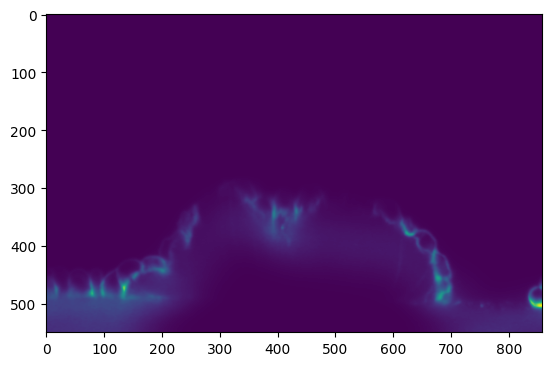

In [43]:
plt.imshow(epithelial_bottom[400])

In [44]:
def shape_finder_2D(height_mask):

    angles = [i for i in range(-60, 60+1, 10)]

    total_cell_mask = np.zeros(shape=(height_mask.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(height_mask, angle, reshape=False) # Be careful of the reshape=False
        # cell_top_mask_rot = rotate(height_matrix, angle)

        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            max_pos = np.argmax(col == max(col))
            # max_pos = find_first_local_max(col)
            if max_pos <= len(col)-200:
                cell_border.append(max_pos) # Search for the first max
            else:
                cell_border.append('-')

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)

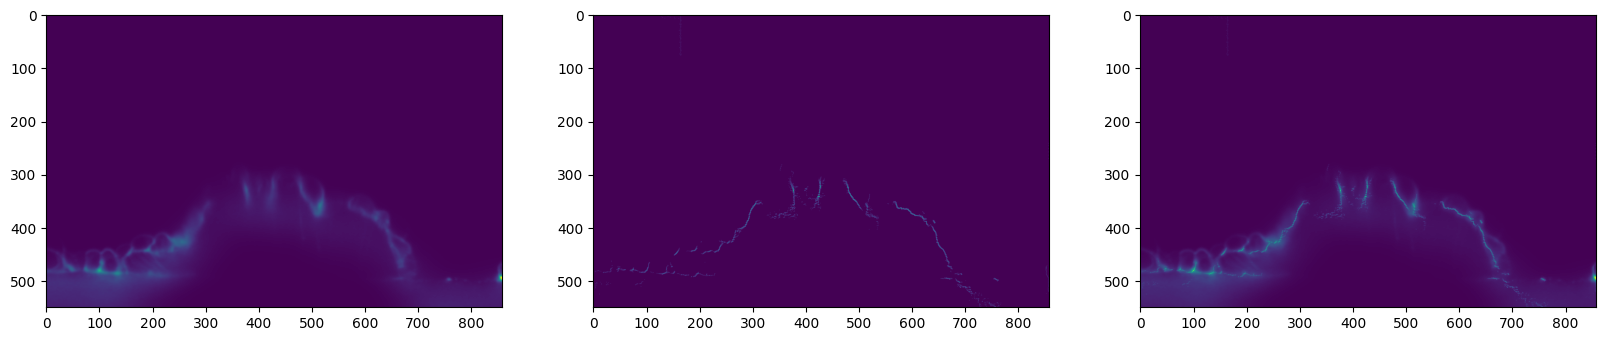

In [58]:
x = 450

plt.figure(figsize=(20,15))
plt.subplot(231)
plt.imshow(epithelial_bottom[x])
plt.subplot(232)
plt.imshow(shape_finder_2D(epithelial_bottom[x]))
plt.subplot(233)
plt.imshow(epithelial_bottom[x]+shape_finder_2D(epithelial_bottom[x]))